# 5. LU Factorization

Both `fbpca` and our own `randomized_range_finder` methods used LU factorization, which factors a matrix into the product of a lower triangular matrix and an upper triangular matrix.

### Gaussian Elimination

This section is based on lectures 20-22 in Trefethen.

If you are unfamiliar with Gaussian elimination or need a refresher, watch [this Khan Academy video](https://www.khanacademy.org/math/precalculus/precalc-matrices/row-echelon-and-gaussian-elimination/v/matrices-reduced-row-echelon-form-2).

Let's use Gaussian Elimination by hand to review:

A =
 \begin{pmatrix}
  1 & -2 & -2 & -3 \\
  3 & -9 & 0 & -9 \\
  -1 & 2 & 4 & 7  \\
  -3 & -6 & 26 & 2
 \end{pmatrix}

#### Answer:

$$ LU = \begin{bmatrix} 1 & 0 & 0 & 0\\ 3 & 1 & 0 & 0 \\ -1 & 0 & 1 & 0 \\ -3 & 4 & -2 & 1\end{bmatrix} \cdot \begin{bmatrix} 1 & -2 & -2 & -3 \\ 0 & -3 & 6 & 0 \\ 0 & 0 & 2 & 4 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

Above example is from Lectures 20, 21 of Trefethen.

**Gaussian Elimination** transform a linear system into an upper triangular one by applying linear transformations on the left.  It is *triangular triangularization*.

$ L_{m-1} \dots L_2 L_1 A = U $

L is *unit lower-triangular*: all diagonal entries are 1

In [206]:
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.eye(n)
    for k in range(n-1):
        for j in range(k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:n] -= L[j,k] * U[k,k:n]
    return L, U

In [207]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [208]:
L, U = LU(A)

In [44]:
np.allclose(A, L @ U)

True

The LU factorization is useful!

Solving Ax = b becomes LUx = b:
1. find A = LU
2. solve Ly = b
3. solve Ux = y

**Work**

Work for Gaussian Elimination: $2\cdot\frac{1}{3} n^3$

**Memory**

Above, we created two new matrices, $L$ and $U$.  However, we can store the values of $L$ and $U$ in our matrix A (overwriting the original matrix).  Since the diagonal of $L$ is all $1$s, it doesn't need to be stored.  Doing factorizations or computations **in-place** is a common technique in numerical linear algebra to save memory.  Note: you wouldn't want to do this if you needed to use your original matrix $A$ again in the future.  One of the homework questions is to rewrite the LU method to operate in place.

Consider the matrix $$ A = \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} $$

In [128]:
A = np.array([[1e-20, 1], [1,1]])

By hand, use Gaussian Elimination to calculate what L and U are:

#### Answer

In [ ]:
#Exercise:


In [123]:
np.set_printoptions(suppress=True)

In [127]:
#Exercise:


In [129]:
L2, U2 = LU(A)

[[  1.00000000e-20   1.00000000e+00]
 [  0.00000000e+00  -1.00000000e+20]]


In [130]:
L2, U2

(array([[  1.00000000e+00,   0.00000000e+00],
        [  1.00000000e+20,   1.00000000e+00]]),
 array([[  1.00000000e-20,   1.00000000e+00],
        [  0.00000000e+00,  -1.00000000e+20]]))

In [84]:
np.allclose(L1, L2)

True

In [85]:
np.allclose(U1, U2)

True

In [86]:
np.allclose(A, L2 @ U2)

False

This is the motivation for $LU$ factorization **with pivoting**.

This also illustrates that LU factorization is *stable*, but not *backward stable*. (spoiler alert: even with partial pivoting, LU is "explosively unstable" for certain matrices, yet stable in practice)

#### Stability

An algorithm $\hat{f}$ for a problem $f$ is **stable** if for each $x$,
$$ \frac{\lVert \hat{f}(x) - f(y) \rVert}{ \lVert f(y) \rVert } = \mathcal{O}(\varepsilon_{machine}) $$

for some $y$ with
$$ \frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine}) $$

**A stable algorithm gives nearly the right answer to nearly the right question** (Trefethen, pg 104)

To translate that:
- right question: $x$
- nearly the right question: $y$
- right answer: $f$
- right answer to nearly the right question: $f(y)$

#### Backwards Stability

Backwards stability is both **stronger** and **simpler** than stability. 

An algorithm $\hat{f}$ for a problem $f$ is **backwards stable** if for each $x$,
$$ \hat{f}(x) = f(y) $$

for some $y$ with
$$ \frac{\lVert y - x \rVert }{\lVert x \rVert} = \mathcal{O}(\varepsilon_{machine}) $$

**A backwards stable algorithm gives exactly the right answer to nearly the right question** (Trefethen, pg 104)

Translation:

- right question: $x$
- nearly the right question: $y$
- right answer: $f$
- right answer to nearly the right question: $f(y)$

### LU factorization with Partial Pivoting

Let's now look at the matrix $$ \hat{A} = \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

In [89]:
A = np.array([[1,1], [1e-20, 1]])

By hand, use Gaussian Elimination to calculate what L and U are:

#### Answer

$$ \hat{L} = \begin{bmatrix} 1 & 0 \\ 10^{-20} & 1 \end{bmatrix} $$
$$ \hat{U} = \begin{bmatrix} 1 & 1 \\ 0 & 1 - 10^{-20} \end{bmatrix} $$

In [90]:
L, U = LU(A)

In [93]:
np.allclose(A, L @ U)

True

Idea: We can switch the order of the rows around to get more stable answers! This is equivalent to multiplying by a permutation matrix $P$.  For instance,

$$\begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 10^{-20} & 1 \\ 1 & 1 \end{bmatrix} =  \begin{bmatrix} 1 & 1 \\ 10^{-20} & 1 \end{bmatrix} $$

$$ PA = \hat{A} $$

Apply Gaussian elimination to $PA$.

At each step, choose the largest value in column k, and move that row to be row k.

#### Homework

In [100]:
def swap(a,b):
    temp = np.copy(a)
    a[:] = b
    b[:] = temp

a=np.array([1,2,3])
b=np.array([3,2,1])
swap(a,b)
a,b

In [102]:
#Exercise: re-write the LU factorization above to use pivoting


#### Example

In [104]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [105]:
L, U, P = LU_pivot(A)

Can compare below to answers in Trefethen, page 159:

In [106]:
A

array([[ 2.,  1.,  1.,  0.],
       [ 4.,  3.,  3.,  1.],
       [ 8.,  7.,  9.,  5.],
       [ 6.,  7.,  9.,  8.]])

In [107]:
U

array([[ 8.        ,  7.        ,  9.        ,  5.        ],
       [ 0.        ,  1.75      ,  2.25      ,  4.25      ],
       [ 0.        ,  0.        , -0.28571429,  0.57142857],
       [ 0.        ,  0.        ,  0.        , -2.        ]])

In [114]:
P

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]])

**Partial pivoting** permutes the rows. It is such a universal practice, that this is usually what is meant by *LU factorization*.

**Complete pivoting** permutes the rows and columns.  Complete pivoting is significantly time-consuming and rarely used in practice.

#### Example

Consider the system of equations:

$$ \begin{bmatrix} 1 & 0 & 0  & 0 & 0 & 1 \\ -1 & 1 & 0  & 0 & 0 & 1 \\ -1 & -1 & 1  & 0 & 0 & 1 \\ -1 & -1 & -1  & 1 & 0 & 1  \\  -1 & -1 & -1  & -1 & 1 & 1 \\ -1 & -1 & -1  & -1 & -1 & 1 \end{bmatrix} \mathbf{x} = \begin{bmatrix} 1 \\ 1 \\ 1  \\ 1 \\ 2 \\ 1 \end{bmatrix} $$

In [99]:
def make_matrix(n):
    A = np.eye(n)
    for i in range(n):
        A[i,-1] = 1
        for j in range(i):
            A[i,j] = -1
    return A 

In [117]:
def make_vector(n):
    b = np.ones(n)
    b[-2] = 2
    return b

In [101]:
make_vector(7)

array([ 1.,  1.,  1.,  1.,  1.,  2.,  1.])

#### Exercise

Exercise: Let's use Gaussian Elimination on the $5 \times 5$ system.

Scipy has this funtionality as well.  Let's look at the solution for the last 5 equations with $n=10,\,20,\,30,\,40,\,50,\,60$.

In [131]:
?scipy.linalg.solve

[-0.00195312 -0.00390625 -0.0078125  -0.015625   -0.03125    -0.0625     -0.125
 -0.25        0.5         1.00195312]
[ -1.90734863e-06  -3.81469727e-06  -7.62939453e-06  -1.52587891e-05
  -3.05175781e-05  -6.10351562e-05  -1.22070312e-04  -2.44140625e-04
  -4.88281250e-04  -9.76562500e-04  -1.95312500e-03  -3.90625000e-03
  -7.81250000e-03  -1.56250000e-02  -3.12500000e-02  -6.25000000e-02
  -1.25000000e-01  -2.50000000e-01   5.00000000e-01   1.00000191e+00]
[ -1.86264515e-09  -3.72529030e-09  -7.45058060e-09  -1.49011612e-08
  -2.98023224e-08  -5.96046448e-08  -1.19209290e-07  -2.38418579e-07
  -4.76837158e-07  -9.53674316e-07  -1.90734863e-06  -3.81469727e-06
  -7.62939453e-06  -1.52587891e-05  -3.05175781e-05  -6.10351562e-05
  -1.22070312e-04  -2.44140625e-04  -4.88281250e-04  -9.76562500e-04
  -1.95312500e-03  -3.90625000e-03  -7.81250000e-03  -1.56250000e-02
  -3.12500000e-02  -6.25000000e-02  -1.25000000e-01  -2.50000000e-01
   5.00000000e-01   1.00000000e+00]
[ -1.81898940e-12

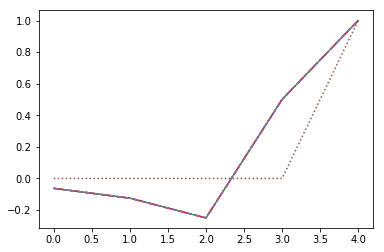

In [112]:
for n, ls in zip(range(10, 70, 10), ['--', ':', '-', '-.', '--', ':']):
    soln = scipy.linalg.lu_solve(scipy.linalg.lu_factor(make_matrix(n)), make_vector(n))
    plt.plot(soln[-5:], ls)
    print(soln)

What is going on when $n=60$?

**Theorem**: Let the factorization $PA = LU$ of a matrix A be computed by Gaussian Elimination with partial pivoting.  The *computed* (by a computer with Floating Point Arithmetic) matrices $\hat{P}$, $\hat{L}$, and $\hat{U}$ satisfy

$$\hat{L}\hat{U} = \hat{P} A + \delta A, \quad \frac{\delta A}{A} = \mathcal{O}(\rho \varepsilon_{machine}) $$

where $\rho$ is the *growth factor*, 

$$\rho = \frac{max_{i,j} \lvert u_{ij} \rvert }{max_{i,j} \lvert a_{ij} \rvert } $$

For our matrix above, $\rho = 2^{m-1}$

#### Unstable in theory, stable in practice

Stability of most algorithms (such as QR) is straightforward.  Not the case for Gaussian Elimination with partial pivoting.  Instability in Gaussian elimination (with or without pivoting) arises only if L and/or U is large relative to the size of A.

Trefethen: "Despite examples like (22.4), Gaussian elimination with partial pivoting is utterly stable in practice... In fifty years of computing, no matrix problems that excite an explosive instability are known to have arisen under natural circumstances." [although can easily be constructed as contrived examples]

Although some matrices cause instability, but extraordinarily small proportion of all matrices so "never" arise in practice for statistical reasons.  "If you pick a billion matrices at random, you will almost certainly not find one for which Gaussian elimination is unstable."

### Further Reading
- Gaussian Elimination/LU factorization-- Trefethn Lecture 20
- Pivoting -- Trefethn Lecture 21
- Stability of Gaussian Elimination -- Trefethn Lecture 22

### What is going on with Randomized Projections?

We are taking a linear combination (with random weights) of the columns in the matrix below:

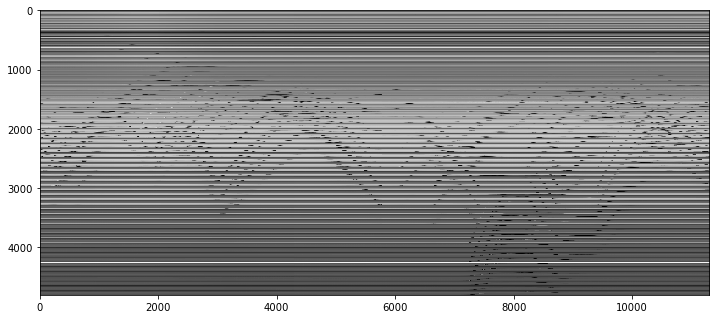

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

It's like a random weighted average.  If you take several of these, you end up with columns that are not highly correlated to each other (roughly orthogonal).

**Johnson-Lindenstrauss Lemma**: ([from wikipedia](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)) a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved.

It is desirable to be able to reduce dimensionality of data in a way that preserves relevant structure. The Johnson–Lindenstrauss lemma is a classic result of this type.

### History of Gaussian Elimination

[Fascinating history of Gaussian Elimination](https://jvns.ca/blog/2017/04/16/making-small-culture-changes/).  Some highlights:

- First written record of Gaussian elimination from ~200 BC in the Chinese book *Nine Chapters on Arithmetic*
- The ancient Chinese used colored bamboo rods placed in columns on a "counting board"
- Japanese mathematicican Seki Kowa (16432-1708) carried forward the Chinese elimintion methods and invented the determinant before 1683.  Around the same time, Leibniz made similar discoveries independently, but neither Kowa nor Leibniz go credit for their discoveries.
- Gauss referred to the elimination method as being "commonly known" and never claimed to have invented it, although he may have invented the Cholesky decomposition

[More history here](http://www.sciencedirect.com/science/article/pii/S0315086010000376)

### Speeding Up Gaussian Elimination

[Parallelized LU Decomposition](https://courses.engr.illinois.edu/cs554/fa2013/notes/06_lu_8up.pdf) LU decomposition can be fully parallelized

[Randomized LU Decomposition](http://www.sciencedirect.com/science/article/pii/S1063520316300069) (2016 article): The randomized LU is fully implemented to run on a standard GPU card without any GPU–CPU data transfer.

### Scipy.linalg solve vs lu_solve

In [210]:
n = 5
A = make_matrix(n)
b = make_vector(n)

A

array([[ 1.,  0.,  0.,  0.,  1.],
       [-1.,  1.,  0.,  0.,  1.],
       [-1., -1.,  1.,  0.,  1.],
       [-1., -1., -1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.]])

This problem has a large *growth factor* $= 2^{59}$.  We get the wrong answer using scipy.linalg.lu_solve, but the right answer with scipy.linalg.solve.  What is scipy.linalg.solve doing?

In [143]:
print(scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), b)[-5:])
print(scipy.linalg.solve(A, b)[-5:])

[ 0.  0.  0.  0.  1.]
[-0.0625 -0.125  -0.25    0.5     1.    ]


In [136]:
%%timeit
soln = scipy.linalg.lu_solve(scipy.linalg.lu_factor(A), b)
soln[-5:]

91.2 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [137]:
%%timeit
soln = scipy.linalg.solve(A, b)
soln[-5:]

153 µs ± 5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Looking at the [source code for scipy](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L25-L224), we see that it is calling the LAPACK routine `gesvx`.  Here is the [Fortran source code for sgesvx](http://www.netlib.org/lapack/explore-html/d0/db8/group__real_g_esolve_ga982d53a8a62d66af9bcaa50642c95ea4.html#ga982d53a8a62d66af9bcaa50642c95ea4) (`s` refers to single, there is also `dgesvx` for doubles and `cgesvx` for complex numbers).  In the comments, we see that it is computing a *reciprocal pivot growth factor*, so it is taking into account this growth factor and doing something more complex than plain partial pivot LU factorization.

## Block Matrices

This is a follow-up to a question about block matrices asked in a previous class.  But first,

### Ordinary Matrix Multiplication

**Question**: What is the computational complexity (big $\mathcal{O}$) of matrix multiplication for multiplying two $n \times n$ matrices $A \times B = C$?

You can learn (or refresh) about big $\mathcal{O}$ on [Codecademy](https://www.codecademy.com/courses/big-o/0/1)

What this looks like:

    for i=1 to n
        {read row i of A into fast memory}
        for j=1 to n
            {read col j of B into fast memory}
            for k=1 to n
                C[i,j] += A[i,k] x B[k,j]
            {write C[i,j] back to slow memory}
            
**Question**: How many reads and writes are made?

### Block Matrix Multiplication

Divide $A,\, B,\, C$ into $N\times N$ blocks of size $\frac{n}{N} \times \frac{n}{N}$

 <img src="images/block_matrix.png" alt="Block Matrix" style="width: 80%"/>
  ([Source](http://avishek.net/blog/?p=804))

What this looks like:

    for i=1 to N
        for j=1 to N
            for k=1 to N
                {read block (i,k) of A}
                {read block (k,j) of B}
                block (i,j) of C += block of A times block of B
            {write block (i,j) of C back to slow memory}
            
**Question 1**: What is the big-$\mathcal{O}$ of this?

**Question 2**: How many reads and writes are made?